#Librerias

In [2]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [3]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays


# Conectar con google drive

In [4]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

# Carga de datos procesados

array([[[244, 164, 175],
        [241, 161, 172],
        [243, 162, 171],
        ...,
        [245, 165, 178],
        [241, 163, 176],
        [238, 160, 173]],

       [[244, 163, 171],
        [242, 161, 169],
        [242, 160, 170],
        ...,
        [243, 163, 176],
        [241, 161, 174],
        [238, 158, 171]],

       [[238, 156, 162],
        [239, 158, 164],
        [240, 159, 166],
        ...,
        [242, 162, 175],
        [240, 160, 173],
        [239, 159, 172]],

       ...,

       [[225, 155, 147],
        [226, 155, 148],
        [229, 158, 152],
        ...,
        [223, 150, 157],
        [226, 155, 161],
        [225, 154, 160]],

       [[224, 156, 147],
        [227, 159, 150],
        [228, 159, 152],
        ...,
        [223, 151, 155],
        [227, 156, 160],
        [227, 156, 159]],

       [[226, 158, 149],
        [226, 158, 150],
        [227, 158, 151],
        ...,
        [225, 153, 157],
        [225, 154, 158],
        [223, 152, 156]]], dtype=uint8)
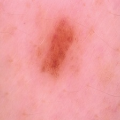

In [6]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [7]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [9]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

## Cargar el modelo entrenado

In [10]:
modelo = tf.keras.models.load_model('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Carga del mejor modelo entrenado

# Análisis del modelo

## Selección de umbrales

En este caso como es el del diagnóstico de cáncer de piel, es muy importante no pasar por alto a personas que realmente están enfermas. Por eso, usamos una estrategia en la que el modelo solo da un diagnóstico automático cuando está muy seguro. Si no está seguro, simplemente clasifica el caso como no identificado y lo deja para que lo revise un médico. Así, el sistema funciona como una primera barrera confiable: toma decisiones claras cuando puede, y en los casos dudosos, pide ayuda humana. Dado esto ya mencionado los umbrales se escogieron de la siguiente manera.

- threshold_pos = 0.95: Alta certeza para clasificar un caso como positivo para cáncer (solo si el modelo tiene alta confianza).

- threshold_neg = 0.08: Alta certeza para clasificar como sano (solo si la probabilidad de cáncer es muy baja).

- Valores intermedios: clasificados como “No identificado”, para ser revisados manualmente por un médico.


## Visualización de probabilidades (Test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step


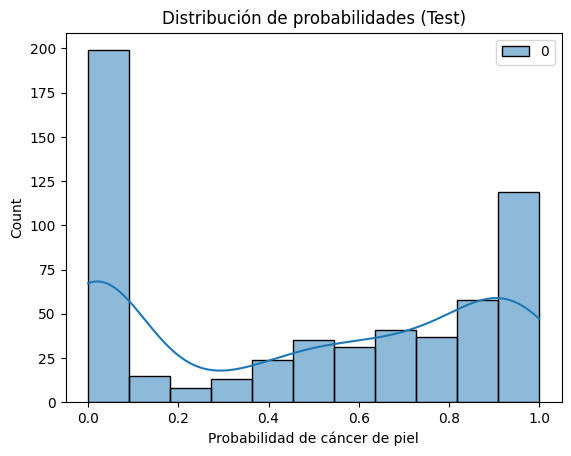

In [11]:
prob_test = modelo.predict(x_test)  # para las probabilidades predichas por el modelo en cada imagen del conjunto de prueba

sns.histplot(prob_test, kde=True)  # Crea un histograma con una curva de densidad (kde)
plt.title("Distribución de probabilidades (Test)")
plt.xlabel("Probabilidad de cáncer de piel") #
plt.show()

El gráfico de distribución de probabilidades para el conjunto de prueba muestra que el modelo asigna frecuencias muy altas de probabilidad cercanas a 0 (es decir, con alta confianza de que no hay cáncer) y también un grupo considerable de casos con probabilidades cercanas a 1 (alta confianza de que sí hay cáncer). Sin embargo, se observa una mayor concentración hacia el extremo izquierdo, lo que sugiere que el modelo es más conservador y tiende a clasificar más casos como "no cáncer".

En la zona intermedia o zonas gris (entre aproximadamente 0.2 y 0.8), las probabilidades están más dispersas, reflejando incertidumbre del modelo en estos casos dejando este intermedio como pacientes que deberian ser revisandos por un medico. Siendo esto util en este contexto puesto que evitamos errores muy criticos como los falsos negativos al reducir la incertidumbre

## Curva ROC y AUC

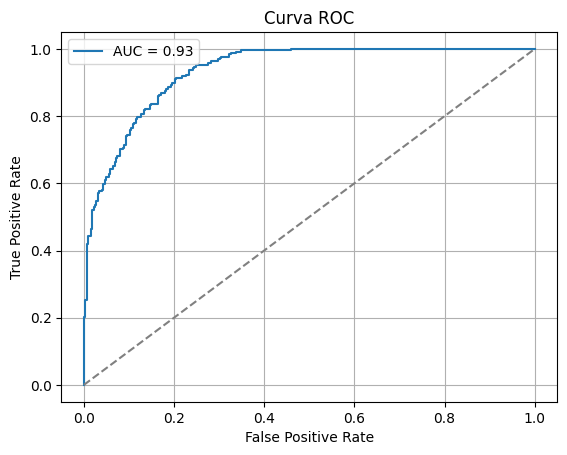

In [12]:
fpr, tpr, _ = metrics.roc_curve(y_test, prob_test) # Calcula las tasas de falsos positivos (fpr) y verdaderos positivos (tpr) con distitos umbralews
auc = metrics.roc_auc_score(y_test, prob_test) # Calcula el AUC, que resume el rendimiento del modelo

# Grafico de la curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}') # dibuja la curva ROC y muestra el valor del AUC
plt.plot([0,1], [0,1], linestyle='--', color='gray') # dibuja la linea diagonal que representa un clasificador aleatorio
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()


En este caso, el área bajo la curva (AUC) es de 0.93, lo que indica un desempeño excelente: el modelo tiene un 93% de probabilidad de asignar una mayor probabilidad a un caso con cáncer que a uno sin cáncer al azar. Además, la curva está muy por encima de la diagonal de referencia (línea gris), lo que confirma que el modelo clasifica significativamente mejor que el azar. Este alto AUC respalda la decisión de usar umbrales personalizados, ya que demuestra que el modelo separa bien ambas clases y permite ajustar el balance entre sensibilidad (detectar cáncer) y especificidad (evitar falsos positivos).

## Evaluación con umbral bajo (más sensible)


### Reporte con umbral bajo (más sensible):
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       322
           1       0.97      0.29      0.45       258

    accuracy                           0.68       580
   macro avg       0.81      0.64      0.61       580
weighted avg       0.79      0.68      0.63       580



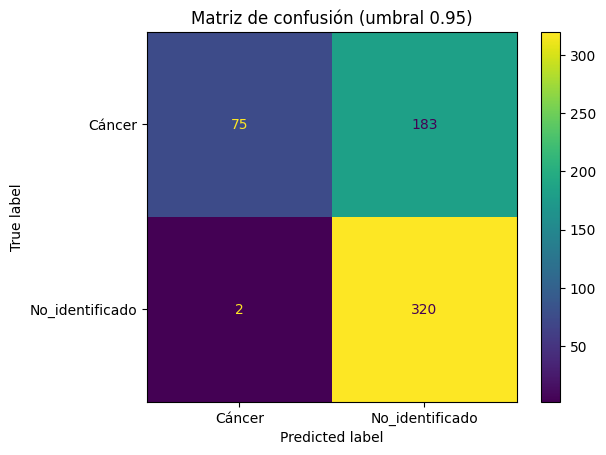

In [13]:
threshold_pos = 0.95  # definicion del umbral más bajo para favorecer la detección de cáncer


pred_test_pos = (prob_test >= threshold_pos).astype('int') # Clasifica como "cáncer" las probabilidades mayores o iguales a 0.45
print("\n### Reporte con umbral bajo (más sensible):")
print(metrics.classification_report(y_test, pred_test_pos)) # Mostrar algunas metricas de clasificación: precisión, recall, F1-score y soporte


# Calcula la matriz de confusión (positiva: 1=cáncer, negativa: 0=normal)
cm = metrics.confusion_matrix(y_test, pred_test_pos, labels=[1,0])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=["Cáncer", "No_identificado"])
disp.plot() # dibujar matriz
plt.title("Matriz de confusión (umbral 0.95)")
plt.show()

En esta evaluación por medio de la matriz de confusion y con un umbral de 0.95, muestra que el modelo como se esperaba es muy conservador al clasificar automáticamente un caso como "cáncer": solo 75 casos fueron identificados directamente como tal, mientras que 183 pacientes con cáncer fueron etiquetados como “no identificados”, lo que implica que requieren revisión médica adicional. Esto reduce significativamente el riesgo de falsos negativos. Por otro lado, solo 2 casos sanos fueron clasificados erróneamente como cáncer, lo que indica un alto nivel de precisión cuando el modelo sí decide predecir. Esta estrategia prioriza la seguridad del paciente, aunque implique mayores costos y una mayor carga para el personal médico en revisar los casos dudosos.


## Evaluación con umbral alto (más específico)


### Reporte con umbral alto (más estricto):
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       322
           1       0.67      1.00      0.80       258

    accuracy                           0.78       580
   macro avg       0.83      0.80      0.78       580
weighted avg       0.85      0.78      0.78       580



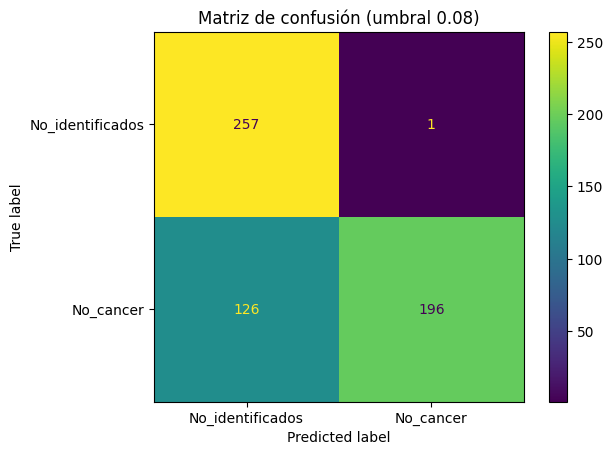

In [14]:
threshold_neg = 0.08  # definicion del umbral más alto para mayor certeza en negativos

pred_test_neg = (prob_test >= threshold_neg).astype('int') # Clasifica como "cáncer" las probabilidades mayores o iguales a 0.55
print("\n### Reporte con umbral alto (más estricto):")
print(metrics.classification_report(y_test, pred_test_neg)) # Mostrar algunas metricas de clasificación: precisión, recall, F1-score y soporte

# Calcula la matriz de confusión (positiva: 1=cáncer, negativa: 0=normal)
cm = metrics.confusion_matrix(y_test, pred_test_neg, labels=[1,0])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=["No_identificados", "No_cancer"])
disp.plot() # dibujar matriz
plt.title("Matriz de confusión (umbral 0.08)")
plt.show()

En esta matriz de confusión con umbral 0.08, el modelo solo clasifica automáticamente como “no cáncer” los casos con altísima certeza, lo que se refleja en 196 clasificaciones correctas y solo 1 error. No obstante, la mayoría de los casos quedan en la categoría de “no identificados” (383 en total), lo que indica nuevamente que el modelo es muy conservador y prefiere abstenerse de tomar decisiones automáticas ante la mínima probabilidad de falla.

## Evaluación en entrenamiento (con umbral sensible)

In [15]:
prob_train = modelo.predict(x_train) # probabilidades predichas por el modelo para los datos de entrenamiento
pred_train = (prob_train >= threshold_pos).astype('int') # conversion de probabilidades a clases binarias (0 o 1) usando el umbral de 0.45

print("\n### Desempeño en entrenamiento (umbral 0.95):")
print(metrics.classification_report(y_train, pred_train))  # reporte de clasificación que muestra métricas

73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step

### Desempeño en entrenamiento (umbral 0.95):
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1278
           1       0.99      0.33      0.50      1039

    accuracy                           0.70      2317
   macro avg       0.82      0.67      0.64      2317
weighted avg       0.80      0.70      0.66      2317



Con un umbral alto de 0.95 durante el entrenamiento, el modelo se vuelve más estricto al clasificar un caso como cáncer. Esto se refleja en una alta precisión del 0.99 para los casos positivos, pero con un recall bajo de 0.33, lo que indica que se están dejando pasar muchos casos reales de cáncer, los cuales claramente deberán ser evaluados por un especialista posteriormente. En contraste, para los casos normales (clase 0), el modelo alcanza un recall perfecto de 1.00, aunque con una precisión más baja (0.65), lo que sugiere una mayor cantidad de falsos positivos

## Clasificación final con zona gris

In [16]:
# Clasificacion segun umbrales
clas = [
    'Normal' if prob <= threshold_neg else
    'Cáncer' if prob > threshold_pos else
    'No_identificado' for prob in prob_test
]

# Contar cada clase
clases, count = np.unique(clas, return_counts=True)

# Mostrar porcentaje por clase
print("\n### Clasificación final con zona gris:")
for c, n in zip(clases, count):
    print(f"{c}: {n} ({n*100/np.sum(count):.2f}%)")


### Clasificación final con zona gris:
Cáncer: 77 (13.28%)
No_identificado: 306 (52.76%)
Normal: 197 (33.97%)


En la clasificación final con zona gris, el modelo etiquetó como “No_identificado” el 52.76% de los casos (306), mostrando como ya se ha mencionado una estrategia conservadora que evita decisiones en situaciones inciertas. El 13.28% (77 casos) se clasificaron como “Cáncer” y el 33.97% (197 casos) como “Normal”. Esta distribución refleja que el modelo delega muchos casos para revisión clínica, lo que es útil para minimizar errores graves, especialmente falsos negativos, manteniendo asi una alta confiabilidad en las predicciones